# Machine Learning LAB 7: CLUSTERING - K-means and DBSCAN

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Import all the necessary Python libraries

In [34]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

np.random.seed(20)

---

## Define the helper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [35]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off') # off removes the axis lines, ticks and labels from the plot (hides the axis so that only the image itself is displayed)
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [36]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1) #rotation=90 for the z-axis rotates the label
                                                      #labelpad=-1 adjusts the padding between the axis and the label (since negative makes the label closer to the axis).
    if title is not None:
        plt.title(title)
    if clusters is None:
        # if no clusters, plot the data in 3D (columns as x,y,z components)
        # color the points based on their values
        # s = 5 sets the size of the points
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        # if clusters is provided, color the points based on their cluster value
        # zorder specifies the layering order of the points (lower values will be plotted behind higher values)
        # alpha = 0.5 makes the points semi-transparent
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [37]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [38]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    if labels is None:
        # if labels is not provided, it plots the errors array, excluding the first and last elements
        # the x-axis is gonna be the index of the plotted list-point
        # The first error value (errors[0]) is typically set to a very large number, often as an arbitrary initialization.
        # At the end of the loop, the final error value gets appended but isn't necessarily used in another iteration.
        # therefore the last error is an extra-value that doesn'r correspond to a valid iteration
        plt.plot(errors[1:-1]) 
        plt.plot(errors[1:-1], 'ro') # overlays red circles ('ro') on the same graph to mark individual points
    else:
        plt.plot(labels, errors) # if label is provided, it uses labels as the x-axis values
        plt.plot(labels, errors, 'ro') 
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [39]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) # spectral colormap uses reds, blues and yellows, but not black
            for each in np.linspace(0, 1, len(unique_labels))] # generates distinct colors for each cluster using the Spectral colormap
    for k, col in zip(unique_labels, colors): # iterate over clusters and corresponding color
        if k == -1: # if points are noise
            # Black used for noise.
            col = [0, 0, 0, 1] # the color in this case is manually set to black [0,0,0,1] (RGBA format)

        class_member_mask = (labels == k) # creates a boolean mask to identify points in the current cluster

        xy = x[class_member_mask] # extract points belonging to cluster k
        # plot the points of this cluster
        # markerfacecolor=tuple(col): fills markers with the cluster color
        # markeredgecolor = 'k': black border for visibility
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14) 
        
        # same points are plotted again but with a smaller marker size 
        # this creates a layered effect, making cluster points more visible
        xy = x[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

---

## A) K-means clustering

Implement the K-means algorithm

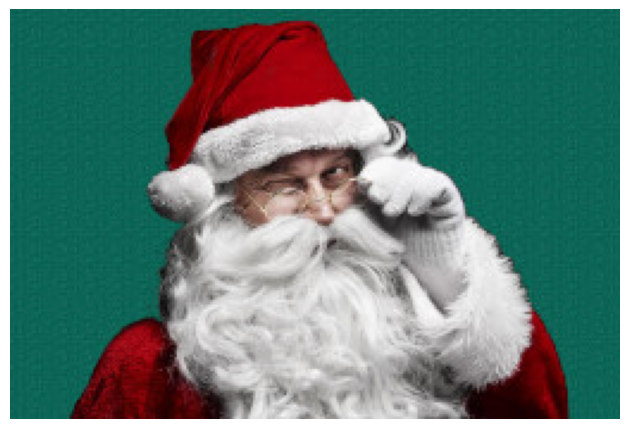

(172, 256, 3)


In [40]:
# Load the provided image and display it (if you like you can experiment with other images)
# To load the images use the function plt.imread(<path_to_iamge>)
santa = plt.imread("data/santaclaus2.jpg")

# Plot the image with its shape
img_plot(santa)
print(santa.shape)

In [41]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
santa_reshaped = np.reshape(santa, (santa.shape[0]*santa.shape[1],santa.shape[2]))
santa_reshaped = santa_reshaped /255

# Print the shape of the data and the min and max values of the pixels
print("shape:",santa_reshaped.shape, "min:", np.min(santa_reshaped),"max:", np.max(santa_reshaped))

shape: (44032, 3) min: 0.0 max: 1.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

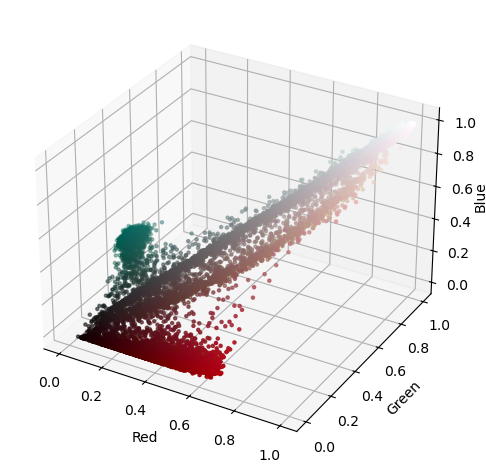

In [42]:
# Suggestion: use the function scatter_plot()

# Basically here each point in the graph is a pixel
# The coordinates of the point are its normalized values of red, green and blue
# Each point, since not clustered yet, has a color determined by its value (combination of rgb, basically the same colour that pixel has in the true image)

scatter_plot(santa_reshaped)

Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). 

- The inputs to the function is:
   1. the set of vectors to be clustered
   2. the number of clusters
   3. maximum number of iterations

- The output must contain:

   1. the clusters barycenters
   2. a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.

Be **careful about the initalization**, you can use some random points from the training set, or get random values but _ensure they are in the proper range_. \
Poor initalizations can lead to the failure of the algorithm (in particular _check that no cluster is initialized as empty_, otherwise the algorithm can not update it).

In [43]:
def kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # TODO Generate random centroids
    # Hint: Use the correct means and standard deviation to ensure they represent the whole input space
    point_count = points.shape[0] # number of data point
    coord_count = points.shape[1] # number of features
    data_means = [0]*coord_count
    data_devs = [0]*coord_count
    for coord in range(coord_count): 
        data_means[coord] = np.mean(points[:,coord])
        data_devs[coord] = np.std(points[:,coord])
    
    centroids = np.ndarray((k,coord_count))
    for num_centroid in range(k):
        for coord in range(coord_count): 
            centroids[num_centroid, coord] = np.random.normal(data_means[coord], data_devs[coord])
    
    clusters = np.ndarray((point_count,)) # this is gonna be an array in which there's the correspoding cluster number of each training point

    # NOTICE: we keep track of the error at the previous iteration (current iteration but before centroids update)
    # and the error after the update because to stop the algorithm we care about the error difference at each step
    prev_error = 1e9+1
    error = [1e9]
    
    # Run the K-means algorithm: until the estimate of centroid is stable (or the maximum number of iterations is reached)
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:
        # TODO: Measure the distance to every centroid
        distances = np.ndarray((point_count,k))
        for point_num in range(point_count): 
            for centroid_num in range(k): 
                distances[point_num, centroid_num] = np.linalg.norm(points[point_num] - centroids[centroid_num])
            
        # TODO: Assign training data to closest centroid
        for point_num in range(point_count): 
            clusters[point_num] = np.argmin(distances[point_num]) # returns the index (hence the cluster number) that minimizes the distance
        
        # TODO: Calculate the new centroids for every cluster 
        for centroid_num in range(k): # update one centroid at a time
            for coord_num in range(coord_count): # to update the centroid you must take the average of each coordinate of points in that cluster
                sum_for_avg = 0
                count_for_avg = 0
                for point_num in range(point_count): 
                    if (clusters[point_num] == centroid_num): # check if the point belongs to cluster of the centroid we're updating
                        count_for_avg +=1 # count the number of points in this cluster (needed to "normalize" the average)
                        sum_for_avg += points[point_num, coord_num] # sum all points values for this coordinate
                #max is here to avoid sporadic "division by 0" errors
                centroids[centroid_num, coord_num] = sum_for_avg/np.max([count_for_avg, 1])

        # Update the error
        prev_error = error[iters]
        current_error = 0 
        # TODO Update the total cost estimate (average L2 loss)
        for point_num in range(point_count): 
            distances = [0]*coord_count
            for coord_num in range(coord_count): 
                # NOTICE: in the following line I need to use int(clusters) because clusters[point_num] is a NumPy scalar, not a native Python integer
                # When indexing a NumPy array, we need the indexes to be INTEGER type, otherwise you get an error
                distances[coord_num] = points[point_num, coord_num] - centroids[int(clusters[point_num]), coord_num]
            current_error += np.sum(np.square(distances))
        current_error /= point_count
        error.append(current_error)
        
        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

Now try the function you developed on the Santaclaus image with three clusters (k=3), then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids). Also, plot the total cost over each iteration. 

[1000000000.0, 0.06177739777505726, 0.025684303596126223, 0.024858601634956148, 0.024823048738009338, 0.02482067965566489, 0.02482020717279825, 0.024820068807450434, 0.0248200564097356, 0.02482005245612733, 0.02482005245612733]


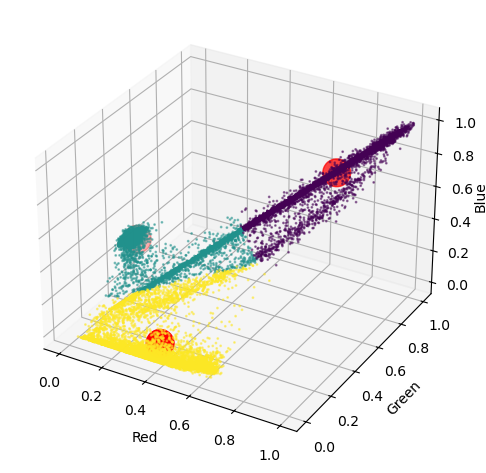

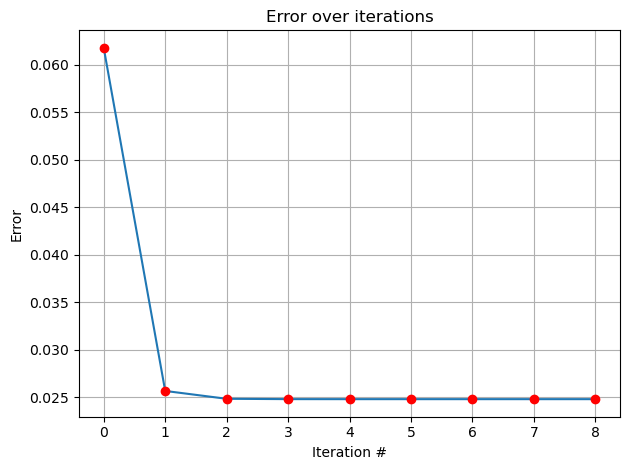

In [44]:
# Run your K-means function on the data
kmeans_centroids, kmeans_clusters, kmeans_errors = kmeans(santa_reshaped, k=3)

# Print the errors:
print(kmeans_errors)

# Plot the results
scatter_plot(santa_reshaped, kmeans_clusters, kmeans_centroids)

# Plot the error
error_plot(kmeans_errors)

Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [45]:
# Define the K-means model
km = KMeans(n_clusters=3,n_init=100) 

# Fit the model to the data
santa_predicted = km.fit_predict(santa_reshaped) # array where each element corresponds to the assigned cluster for each data point
santa_reshaped_compressed = np.copy(santa_reshaped)
for i in range(santa_reshaped_compressed.shape[0]):
    # give to each pixel the value of the centroid color (corresponding to its assigned cluster)
    santa_reshaped_compressed[i]=km.cluster_centers_[santa_predicted[i]]

# Get the cluster centers
centers = km.cluster_centers_ 

Perform the same plot as above but with the output of the k-means function provided in sklearn.

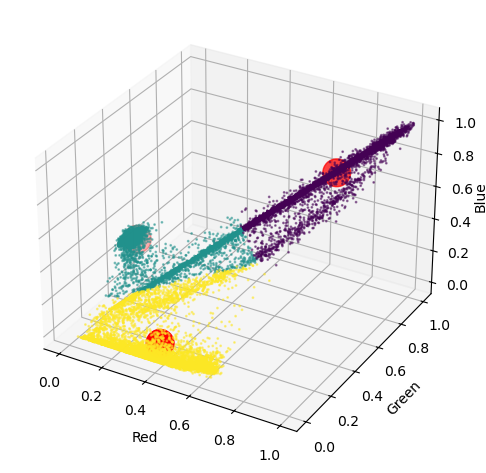

In [46]:
scatter_plot(santa_reshaped, santa_predicted, centers)

### TO DO [Answer the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER:** 
The two plots are almost identical. The assignment to cluster numbers (the cluster ordering) is different (might be, meaning that one time the yellow group is cluster 2, another time is 0 ...), but this has to be expected since it is an unsupervised learning problem. 


Now display the segmented image based on the clusters found above with the k-means functions by sklearn and by your own K-means implementation.

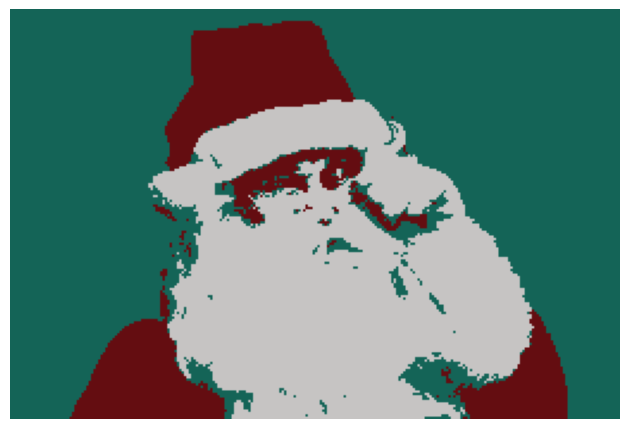

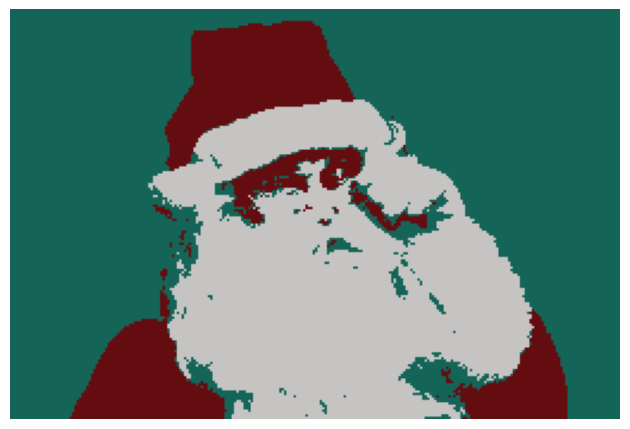

In [47]:
# Extract the color values of the centers
color_centers = centers*255

# Reshape the data to the original image shape
santa_processed = np.reshape(santa_reshaped_compressed, santa.shape)

# Plot the recolored image
img_plot(santa_processed)

# Extract the color values of the centers
kmeans_color_centers = kmeans_centroids*255

# Reshape the data to the original image shape
kmeans_santa_reshaped_compressed = np.copy(santa_reshaped)
for i in range(kmeans_santa_reshaped_compressed.shape[0]):
    kmeans_santa_reshaped_compressed[i]=kmeans_centroids[int(kmeans_clusters[i])]
kmeans_santa_processed = np.reshape(kmeans_santa_reshaped_compressed, santa.shape)

# Plot the recolored image
img_plot(kmeans_santa_processed)

## B) DBSCAN clustering

Now, let's try DBSCAN: implement the algorithm with $\varepsilon=0.1$ and $M=10$ (i.e., the minimum number of neighbors). 

- The **output** should be a **list of indices for all points**, indicating which cluster each point belongs to.
  
-  **Outliers are in cluster 0**, all other points have a positive index. For efficiency, we should compute a _distance matrix first_.

NOTICE: Additionally, since DBSCAN is much more complex, we will try it on a smaller dataset

In [50]:
# Load sample data
data = np.load("data/moon_data.npz") #npz contains multiple numpy arrays that are labelled

# Extract data
x = data['X']
print(x)
labels_true = data['labels_true'] 

[[-0.51671142  0.12336816]
 [-1.05205683  1.21547148]
 [-0.62674339 -0.09401812]
 ...
 [ 1.36142844 -1.12026291]
 [ 0.4792162   0.76152417]
 [-0.37279003 -0.22398523]]


In [55]:
def distance_matrix(points):
    point_count = points.shape[0]
    distances = np.zeros((point_count, point_count))
    for i in range(point_count): # compute distances of each point from all other points
        array_points = np.asarray(points - points[i, :])
        distances[i, :] = np.linalg.norm(array_points,axis=1)
        distances[i,i] = 1e9 # this avoids putting the point itself in neighbors 
    return distances

"""
NOTICE: 
(distance < epsilon): returns a matrix of the same shape of distances with True where the condition is met and False otherwise. 
np.where(condition): returns the indices where the condition is True. 
                    Since distances < epsilon is a 2D matrix, np.where() returns two arrays: (row_indices, col_indices)
                    where row_indices[i] gives the row index of a True value
                          col_indices[i] gives the column index of a True value
Therefore, np.where(distances < epsilon)[0] extracts only the row indices, hence the indexes of rows that have a True, so 
this means it returns a 1D array containing the indices of the points that have at least one neighbor within epsilon.
N.B: this is fine because you don't need to know what point is the neighbor or how many neighbors there are since you're checking
this for all points and you don't want to count twice (or more than twice) the same couple of neighbors. 
"""

def find_neighbors(distances, epsilon):
    return np.where(distances < epsilon)[0] 

def dbscan(points, epsilon, M):
    point_count = points.shape[0]
    coord_count = points.shape[1]
    distances = distance_matrix(points)
    print("Number of points:", point_count)
    C = 0
    done = False # the algorithm runs up to when there are unassigned points
    # The clusters vector contains the assigned cluster values: -1 means unassigned, 0 means outlier, clusters have >=1 values
    clusters = -np.ones(point_count) # start with all unassigned points
    while (not done):
        done = True # you start by setting done = True (because it might be true at next iteration) and then if there are still unassigned (at the first unassigned point you find) you set it back to false
                    # basically if you find a neighbor this is not the very last step: you must at least iterate once more on that very last neighbor
        # TODO: While there are still unassigned points, iterate over them
        for idx in range(point_count): 
            if (clusters[idx] < 0): 
                # There are still unassigned points
                done = False
                neighborhood = find_neighbors(distances[idx,:], epsilon)
                # If there are not enough neighbors classify as outlier
                if (len(neighborhood) < M):
                    clusters[idx] = 0
                else: # otherwise make a new cluster and assign that point to it
                    C += 1
                    clusters[idx] = C
                    done_cluster = False # Now we build the whole cluster 
                    # Check neighbors (until there are some): if the neighbor was an outlier or unassigned, put it in C
                    while (not done_cluster): 
                        done_cluster = True 
                        for next_idx in neighborhood: 
                            # The neighbor was an outlier: move it to cluster C
                            if (clusters[next_idx] == 0): 
                                done_cluster = False
                                clusters[next_idx] = C
                            # The neighbor was unassigned: move it to cluster C and check its own neighbors
                            if (clusters[next_idx] < 0): 
                                done_cluster = False
                                clusters[next_idx] = C
                                new_neighborhood = find_neighbors(distances[next_idx,:], epsilon)
                                if (len(new_neighborhood) >= M): 
                                    # Expand the neighborhood to include the neighbors's neighbors
                                        neighborhood = list(set(neighborhood).union(new_neighborhood)) # .union is a set method, makes the union between two sets 
    return clusters

Let's try and plot it! Noise points will be in red. How do the clusters look like?

Number of points: 1500


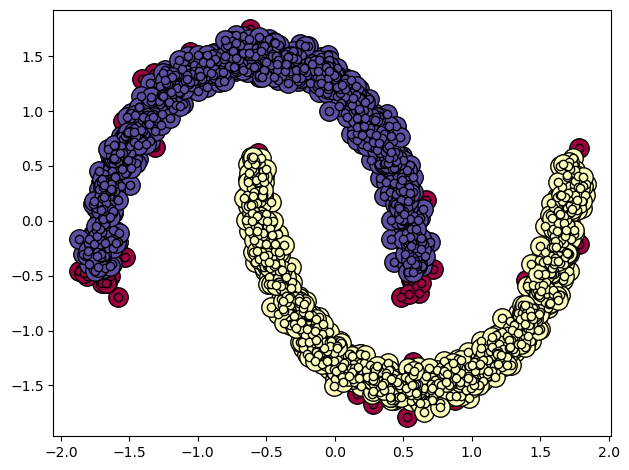

In [56]:
clusters = dbscan(x, epsilon=0.1, M=10)
cluster_plot(clusters,x)

**COMMENT:**
You can see there are clearly two clusters: this is a shape that would be impossible with k_means because it would end up cutting in half linearly the two groups (can't have this nice curved boundaries that are not convex). \
Red points on the edge are noise points that are not close enough to any of the points. 

---